<h1>Calibration for the removal of batch effect</h1>

In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.normalisation.normalise import Normalise, EvaluateBatchEffects, CalibrationError
from immunova.flow.supervised_algo.utilities import calculate_ref_sample_fast, find_common_features
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

In [3]:
texp = FCSExperiment.objects(experiment_id='PD_T_PDMCs').get()

<h2>Calculate Reference Sample</h2>

I calculate the reference sample by calculating the covariance matrix of each sample. Then for each pair of samples `i` and `j` I calculate the euclidean norm of the difference between their covariance matrices. The reference sample is chosen as the sample with the smallest average distance to all other samples. This reference sample will be used as the target in training the MDD-ResNet model.

In [4]:
invalid = [f'{x}_pdmc_t' for x in ['209-03', '210-14', '273-01', '298-01', '322-01', '237-06', '302-01']]
samples = [x for x in texp.list_samples() if x not in invalid]

In [5]:
reference_sample = calculate_ref_sample_fast(texp, exclude_samples=invalid, sample_n=1000)

In [6]:
reference_sample

'288-02_pdmc_t'

In [5]:
reference_sample = '288-02_pdmc_t'

<h2>How bad is the batch effect problem?</h2>

First I will observe the variation of individual markers in each sample and see how they compare to the reference sample (red) by overlaying their KDE.

Then I will generate a PCA for each sample (red) compared to the reference sample (blue).

This will give some indication as to how bad the batch effects are.

In [13]:
batch_effects = EvaluateBatchEffects(experiment=texp, transform='logicle')

Population single_Live_CD3+ not recognised
307-01_pdmc_t does not contain the population single_Live_CD3+, skipping


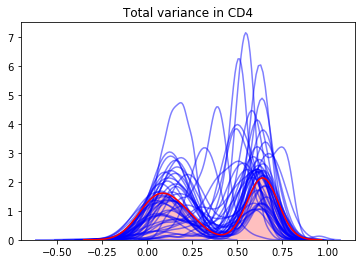

In [14]:
batch_effects.marker_variance(reference_id='288-02_pdmc_t', 
                              root_population='single_Live_CD3+',
                             marker='CD4')

Population single_Live_CD3+ not recognised
307-01_pdmc_t does not contain the population single_Live_CD3+, skipping


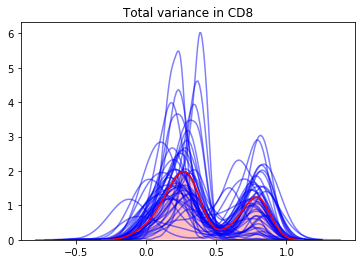

In [15]:
batch_effects.marker_variance(reference_id='288-02_pdmc_t', 
                              root_population='single_Live_CD3+',
                             marker='CD8')

Population single_Live_CD3+ not recognised
307-01_pdmc_t does not contain the population single_Live_CD3+, skipping


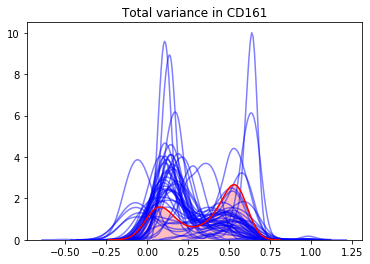

In [16]:
batch_effects.marker_variance(reference_id='288-02_pdmc_t', 
                              root_population='single_Live_CD3+',
                             marker='CD161')

Population single_Live_CD3+ not recognised
307-01_pdmc_t does not contain the population single_Live_CD3+, skipping


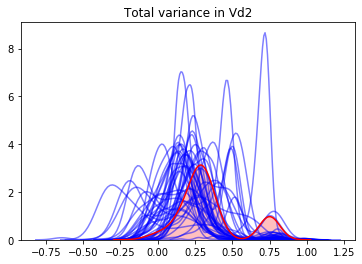

In [17]:
batch_effects.marker_variance(reference_id='288-02_pdmc_t', 
                              root_population='single_Live_CD3+',
                             marker='Vd2')

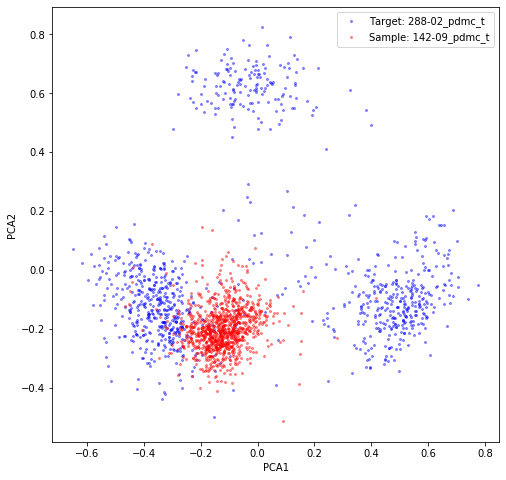

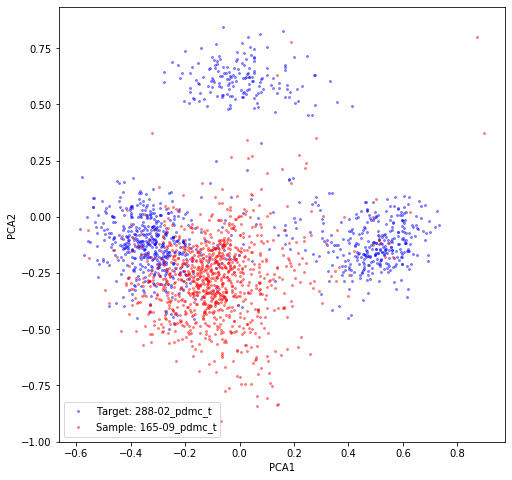

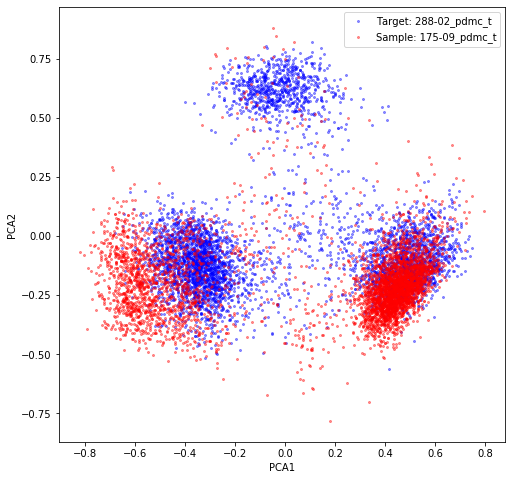

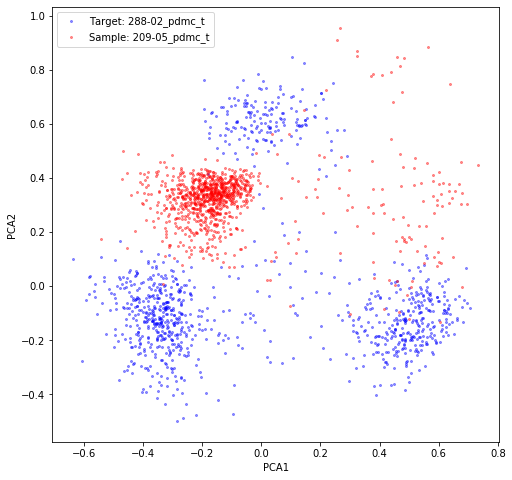

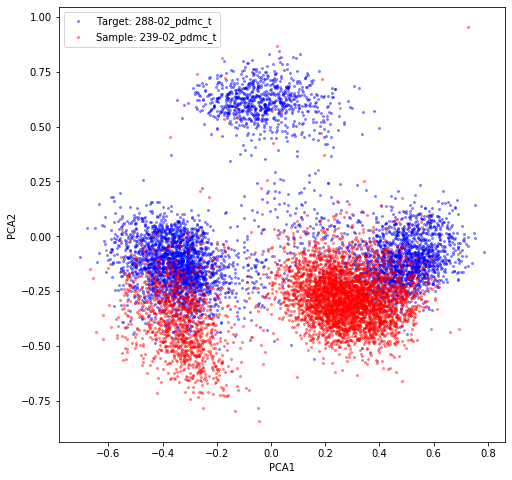

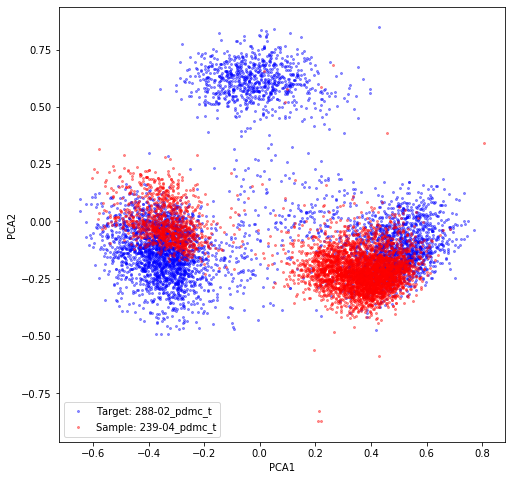

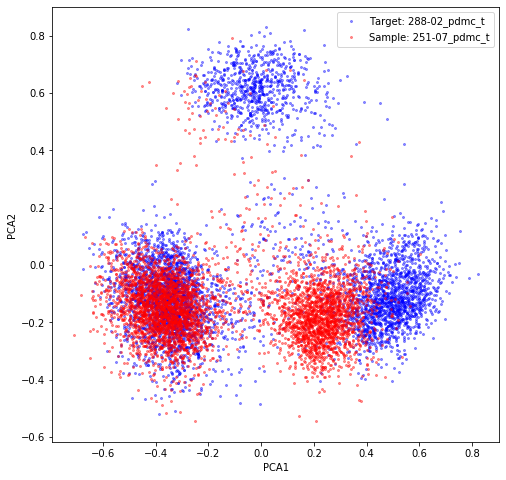

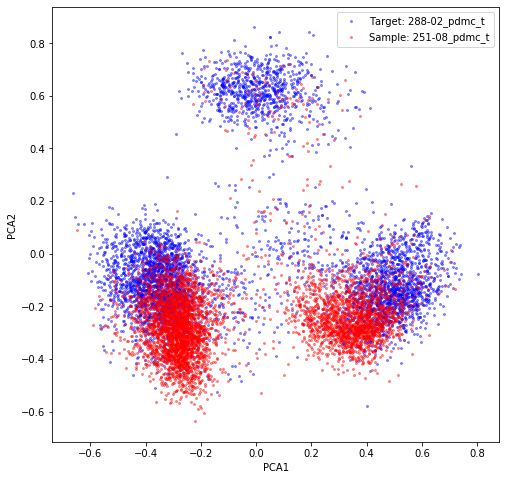

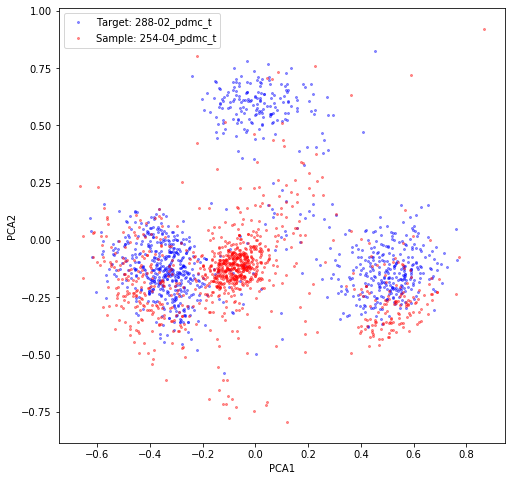

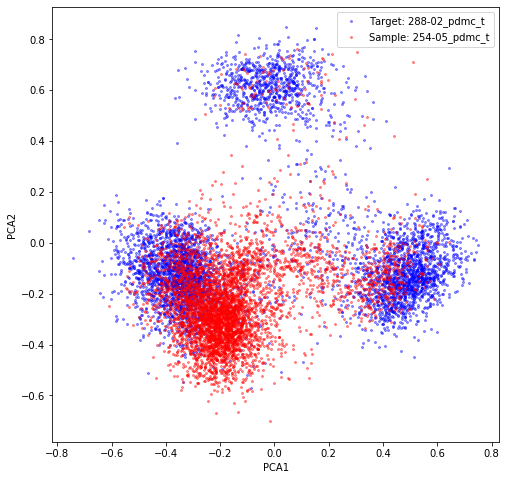

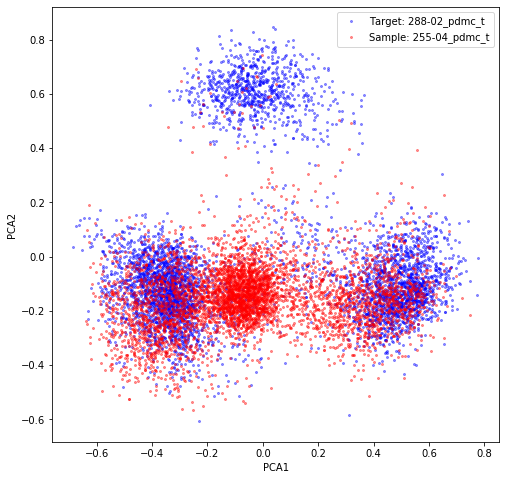

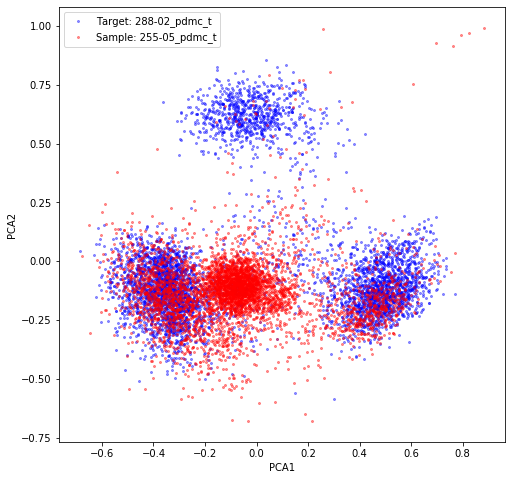

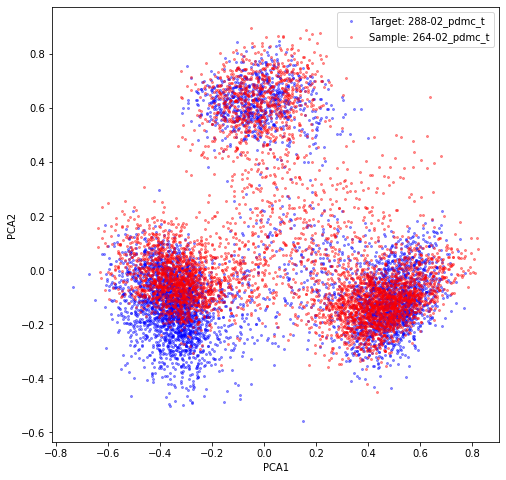

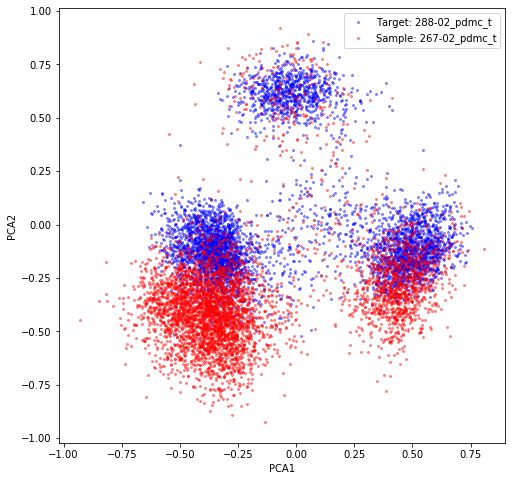

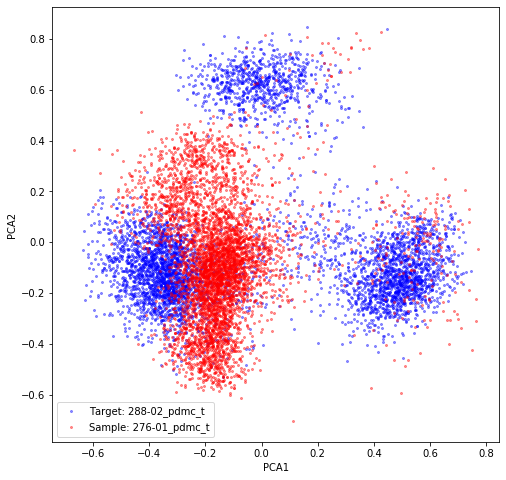

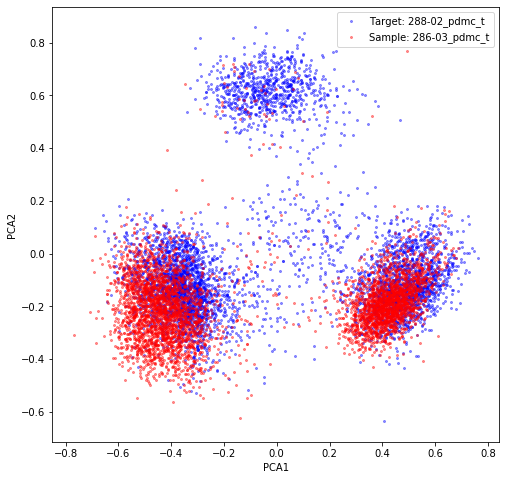

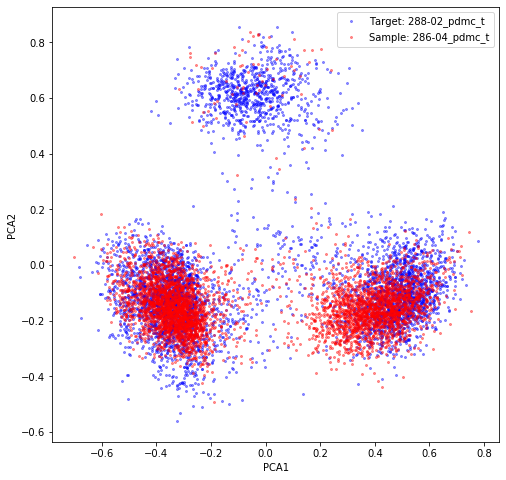

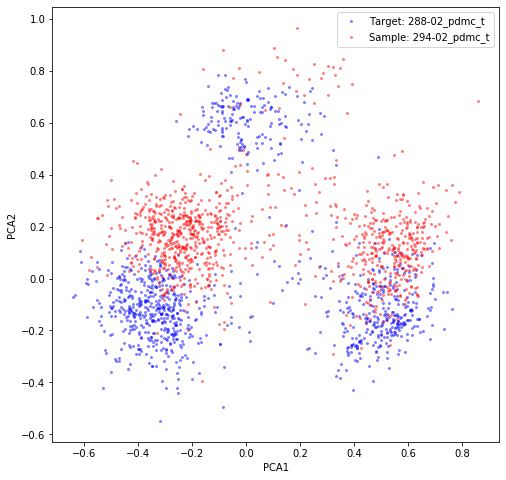

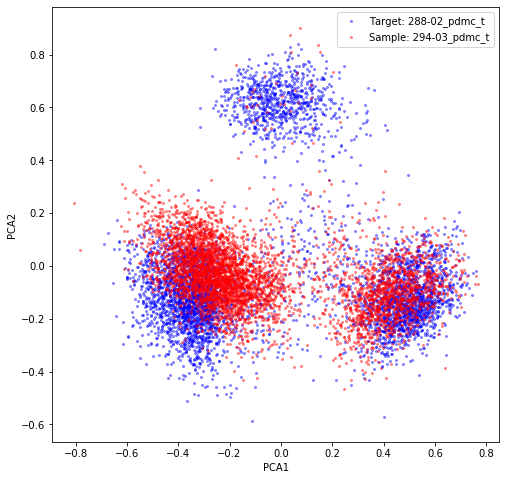

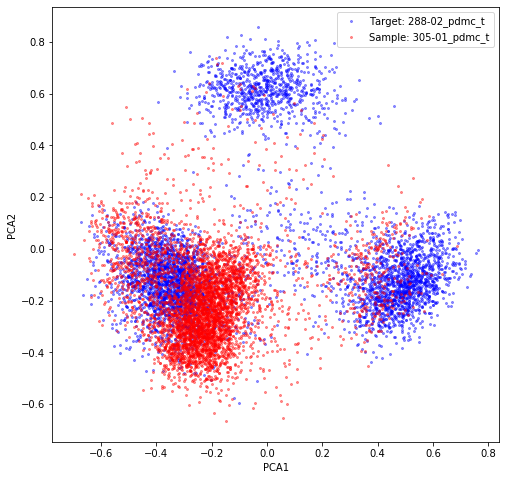

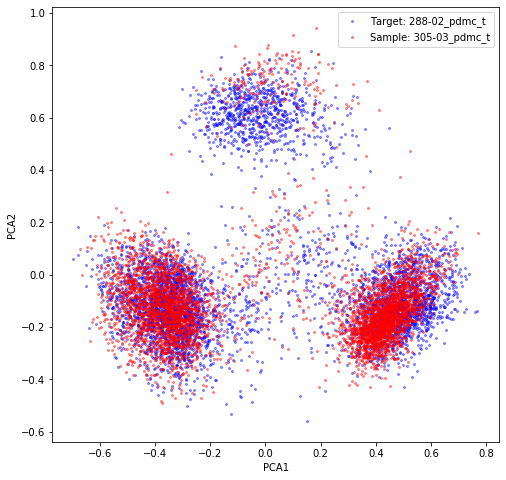

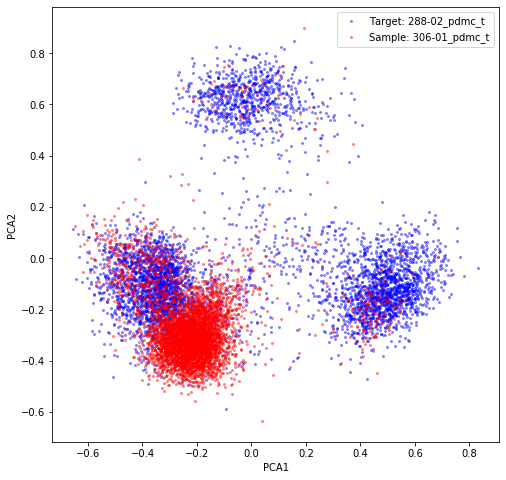

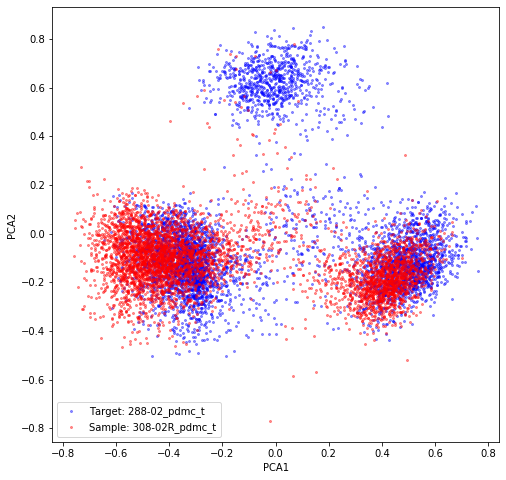

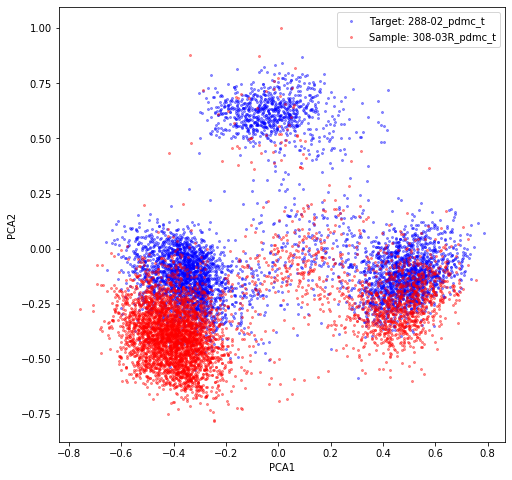

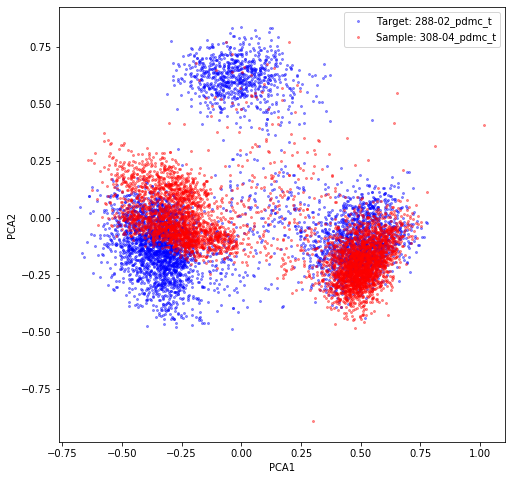

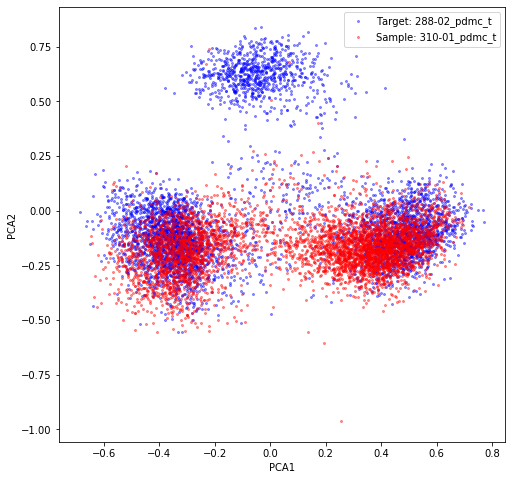

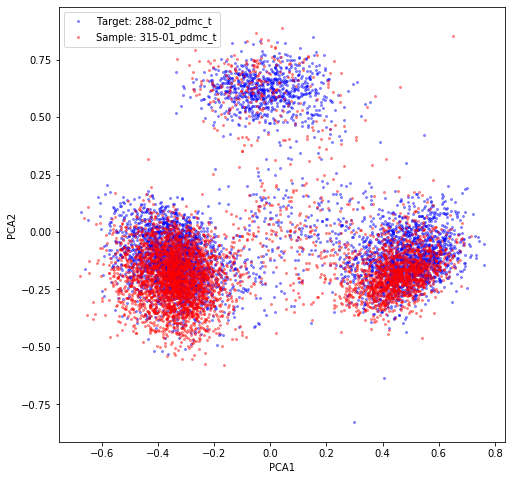

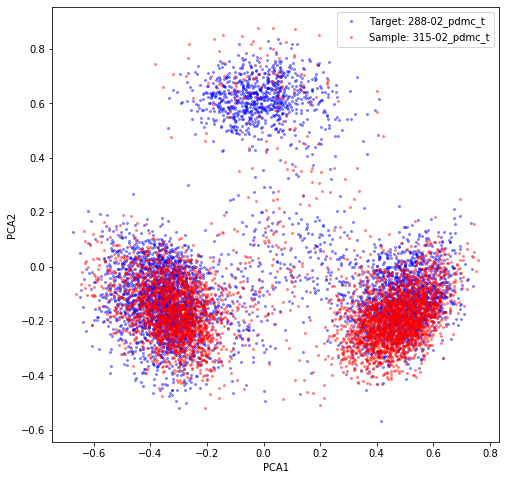

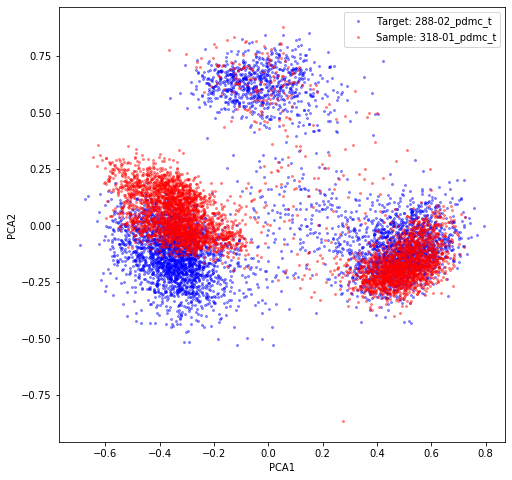

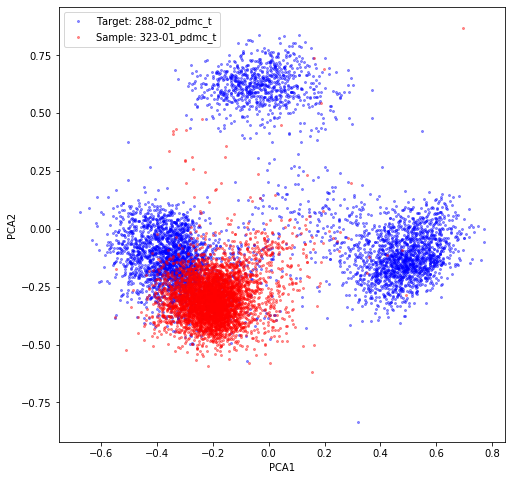

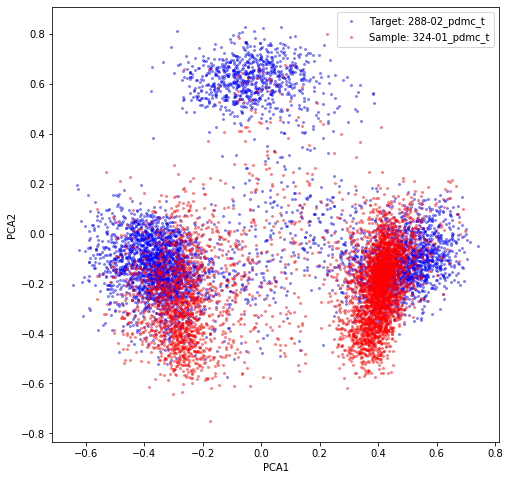

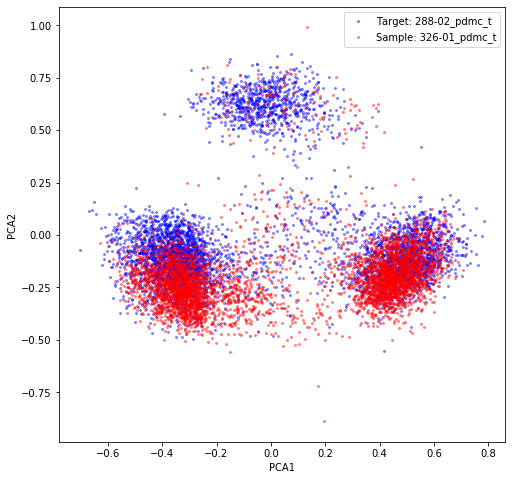

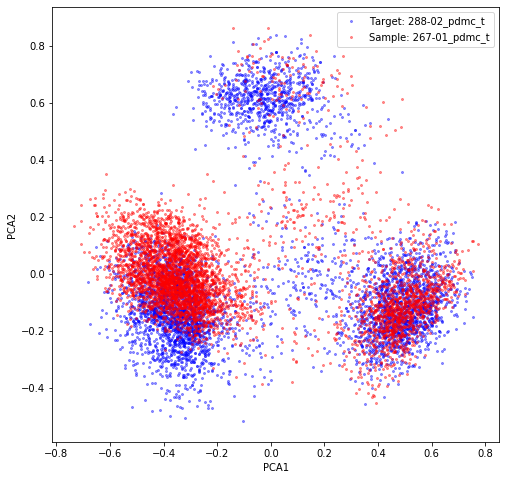

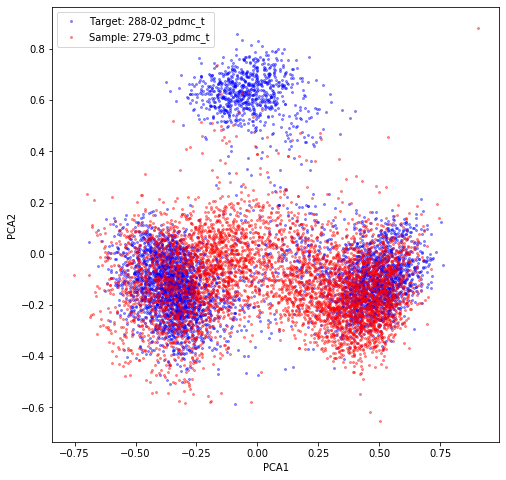

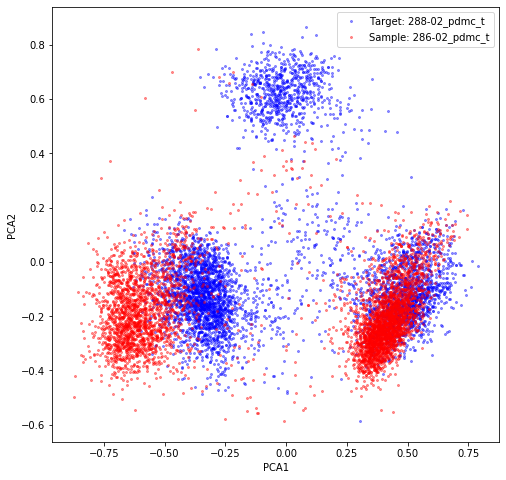

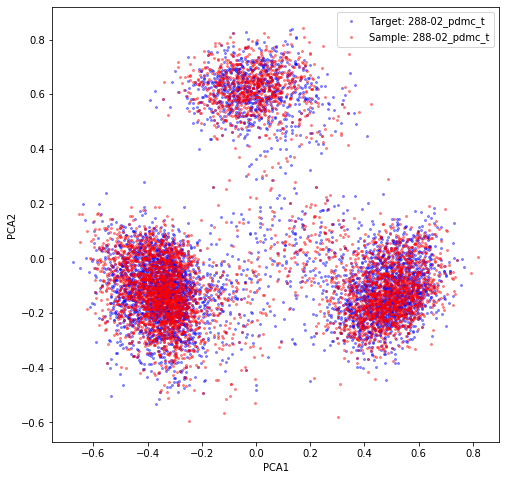

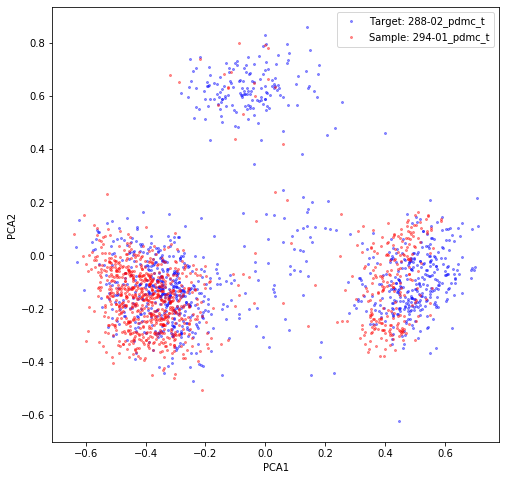

Population single_Live_CD3+ not recognised
Failed: skipping 307-01_pdmc_t


In [12]:
for x in samples:
    try:
        batch_effects.pca(sample_id=x, 
                          reference_id='288-02_pdmc_t',
                          root_population='single_Live_CD3+',
                          sample_n=5000)
    except ValueError:
        batch_effects.pca(sample_id=x,
                          reference_id='288-02_pdmc_t',
                          root_population='single_Live_CD3+',
                          sample_n=1000)
    except CalibrationError:
        print(f'Failed: skipping {x}')

<h2>Removing Batch Effects with MMD-ResNet</h2>

So the batch effects are considerably bad. I have implemented MMD-ResNet as discribed here: https://arxiv.org/pdf/1610.04181.pdf. I will train the model using the reference sample and fit to sample 318-01 (which shows reasonable difference to the reference sample in the PCA plots above). The objective here is to see whether MMD-ResNet reduces MMD between the source and target embeddings without disrupting the underlying biological signals present in the flow cytometry data.

In [ ]:
features = find_common_features(experiment=texp)

In [6]:
features = ['CD45RA',
 'Va7.2',
 'FSC-A',
 'FSC-H',
 'SSC-A',
 'CD161',
 'CD8',
 'CXCR3',
 'Vd2',
 'CD4',
 'CD3',
 'CD27',
 'PanGD',
 'L/D',
 'CCR7',
 'SSC-W']

In [7]:
norm = Normalise(experiment=texp,
                source_id='318-01_pdmc_t',
                root_population='single_Live_CD3+',
                features=features,
                reference_sample=reference_sample,
                transform='logicle',
                epochs=200)

In [8]:
%matplotlib qt
norm.calibrate(evaluate=True)

setting scales using KNN
Scales: [1.463814207209771, 2.927628414419542, 5.855256828839084]
setting all scale weights to 1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 52127 samples, validate on 5792 samples
Epoch 1/500
52127/52127 [==============================] - 6s 114us/step - loss: 0.5716 - val_loss: 0.9606
Epoch 2/500
52127/52127 [==============================] - 5s 99us/step - loss: 0.2420 - val_loss: 0.9004
Epoch 3/500
52127/52127 [==============================] - 5s 98us/step - loss: 0.2000 - val_loss: 0.8603
Epoch 4/500
52127/52127 [==============================] - 5s 99us/step - loss: 0.1894 - val_loss: 0.8156
Epoch 5/500
52127/52127 [==============================] - 5s 100us/step - loss: 0.1837 - val_loss: 0.7608
Epoch 6/500
52127/52127 [==============================] - 5s 99us/step - loss: 0.1787 - val_loss: 0.6795
Epoch 7/500
52127/52127 [==============================] - 5s 99us/step - loss: 0.1766 - val_lo

In [9]:
# Save normalisation for source 318-01
norm.normalise_and_save()

Saving normalised data for 318-01_pdmc_t population single_Live_CD3+
Save complete!


In [10]:
# Save model
norm.calibrator.save_model('models/calibrator_source31801_target28802',
                          'models/calibrator_source31801_target28802_weights')

In [11]:
source = Gating(texp,
                '318-01_pdmc_t',
                include_controls=False).get_population_df('single_Live_CD3+',
                                                          transform=True)[features]
target = Gating(texp,
                '288-02_pdmc_t',
                include_controls=False).get_population_df('single_Live_CD3+',
                                                          transform=True)[features]

<h2>Evaluating the performance</h2>

In [13]:
from sklearn.preprocessing import StandardScaler
sc = source.columns
tc = target.columns
x = StandardScaler().fit(source)
source = pd.DataFrame(x.transform(source), columns=sc)
target = pd.DataFrame(x.transform(target), columns=tc)

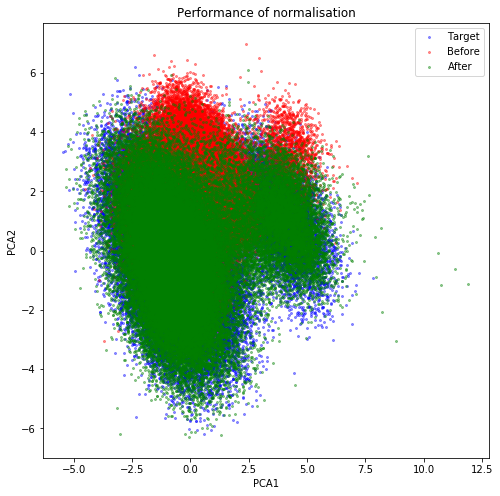

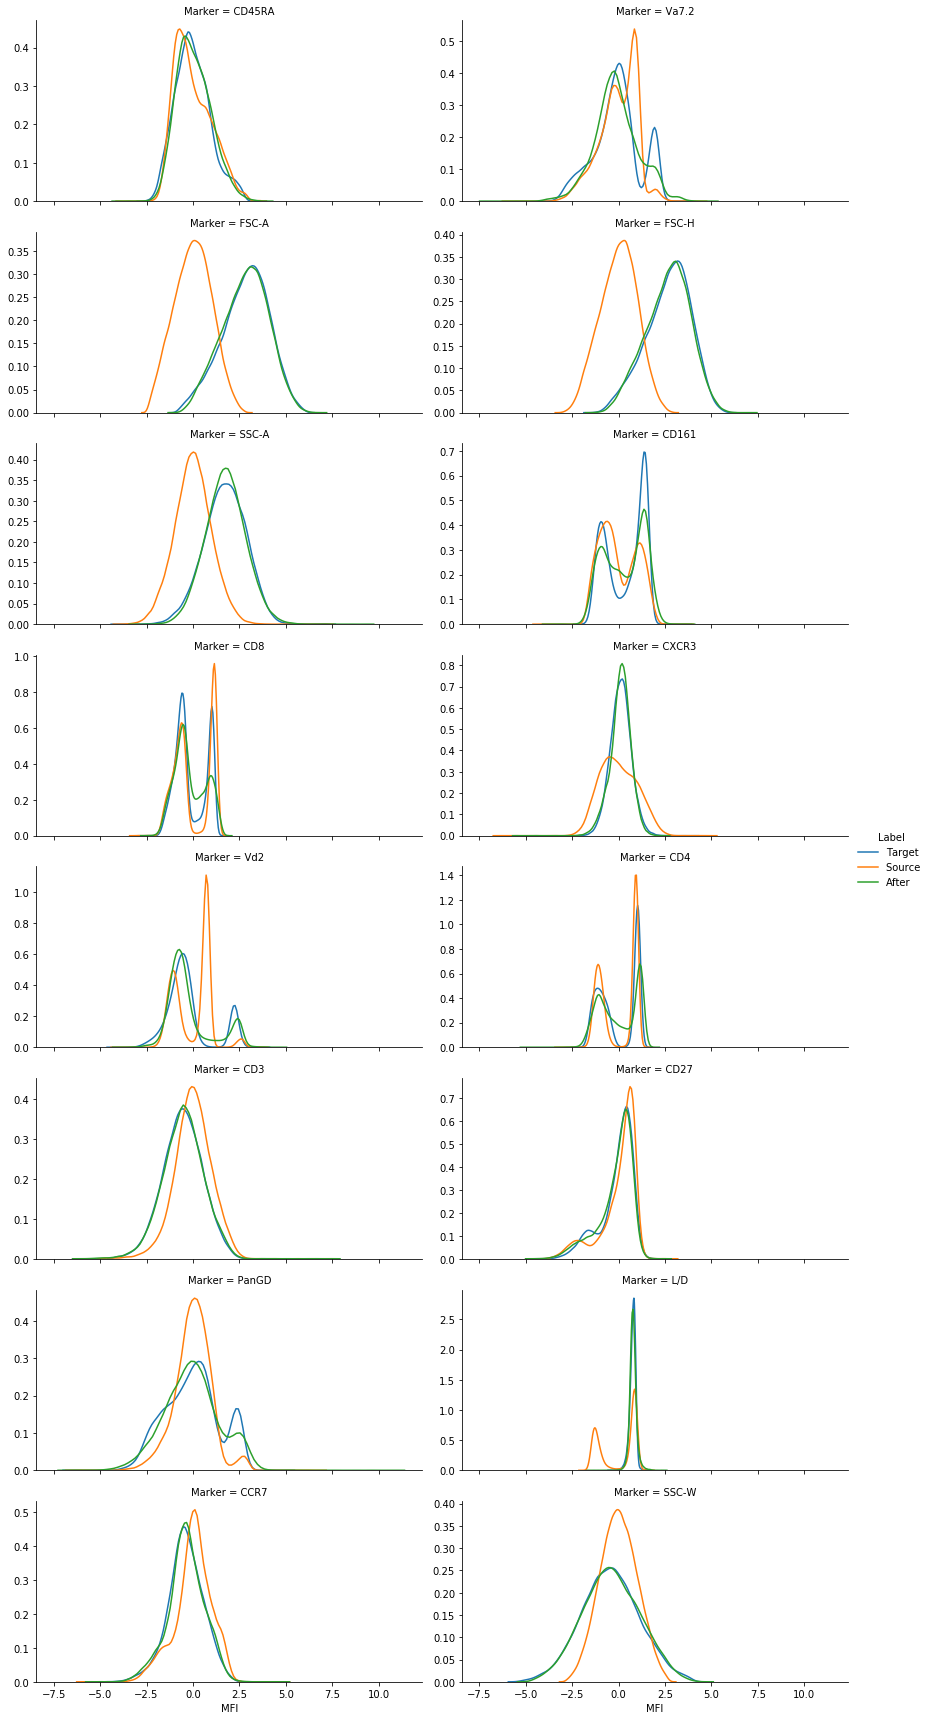

In [14]:
%matplotlib inline
norm.calibrator.evaluate(source, target)

Although in the PCA plot we can see that the source and target have been aligned, there is possible loss of resolution in the underlying biological signal. For example:
* CD4 loses the subtle positive population completely. 
* Vd2 and Va7.2 show double positives (one large the other small) which appear to have been merged together.

This is further demonstrated by the 2D plots below that show complete distortion of the CD4, CD8, and gamma delta T cell populations after calibration.

In [21]:
calibrated = pd.DataFrame(norm.calibrator.model.predict(source), columns=source.columns)

In [27]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def pop_plot(data, x, y, title):
    fig, ax = plt.subplots()
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    ax.set_title(title)
    plt.show()

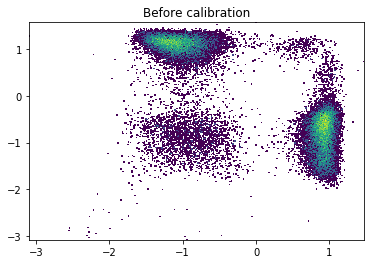

In [28]:
pop_plot(source, 'CD4', 'CD8', 'Before calibration')

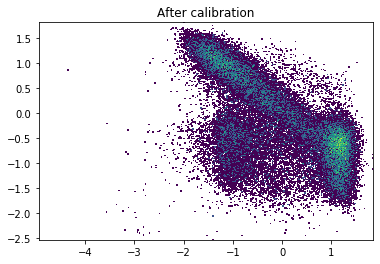

In [29]:
pop_plot(calibrated, 'CD4', 'CD8', 'After calibration')

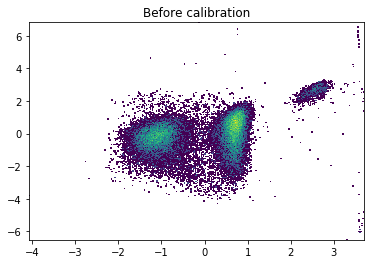

In [30]:
pop_plot(source, 'Vd2', 'PanGD', 'Before calibration')

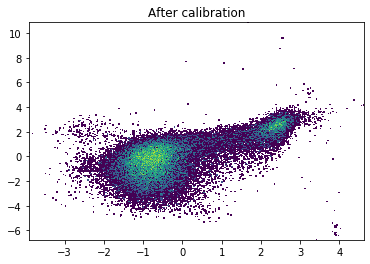

In [31]:
pop_plot(calibrated, 'Vd2', 'PanGD', 'After calibration')